# HOSPITAL DISCHARGE DATASET (2012) FOR NY STATE

# Table of Contents: OSEMN PIPELINE:
## <a href='#Part_1'> O - Obtaining our Data</a> 
## <a href='#Part_2'> S - Scrubbing our Data</a>   
## <a href='#Part_3'> E - Exploring our Data</a>
## <a href='#Part_4'> M - Modeling our Data</a> 
## <a href='#Part_5'> N - Now, for the Final Model:)</a>
## <a href='#Part_6'> Conclusions</a>
## <a href='#Part_7'> Recommendations</a>
## <a href='#Part_8'> Future Work</a>

In [252]:
#Importing all the necessary libraries
import os
import pandas as pd
import numpy as np
import patsy as py
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import xgboost as xgb
import waterfall_chart
from patsy import dmatrices
from xgboost import XGBClassifier
from sklearn import svm, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, make_scorer
from sklearn.metrics import precision_recall_fscore_support, classification_report, roc_auc_score, SCORERS, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from statsmodels.api import Logit
from treeinterpreter import treeinterpreter as ti
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%run functions.ipynb
%matplotlib inline

<a id='Part_1'></a>

# Obtaining our Data:

In [253]:
df = pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2012.csv')

<a id='Part_2'></a>

# Scrubbing our Data:

In [254]:
# cleaning the data set up
# first dropping all columns that are not relevant and/or have a lot of missing data
df.drop(['Health Service Area', 'Operating Certificate Number', 'Discharge Year', 'Facility ID', 'Operating Provider License Number', 'Other Provider License Number', 'Birth Weight', 'Abortion Edit Indicator', 'Payment Typology 2', 'Payment Typology 3'], axis=1, inplace=True)
# changing the 120+ data value to an integer = 150
df['Length of Stay'].replace(to_replace='120 +', value= '150', inplace=True)
df['Length of Stay'] = df['Length of Stay'].astype(int)
# dropping rows with null values 
df = df.dropna(axis=0)
# dropping rows with unknown/unavailable values
df = df.drop(df[df.Gender == 'U'].index)
df = df.drop(df[df.Race == 'Unknown'].index)
df = df.drop(df[df.Ethnicity == 'Unknown'].index)
df = df.drop(df[df['Payment Typology 1'] == 'Unknown'].index)
df = df.drop(df[df['Type of Admission'] == 'Not Available'].index)
df = df.drop(df[df['Patient Disposition'] == 'Another Type Not Listed'].index)
# encoding 0,1 for binary categorical variables
df.Gender= df.Gender.map({'F': 0, 'M': 1}).astype(int)
df['Emergency Department Indicator'] = df['Emergency Department Indicator'].map({'Y': 1, 'N': 0})
df.columns = df.columns.str.replace(' ', '_')

### Adding a column that calculates the Operating Margin:
#### Formula = ( Total Charges - Total Costs - Average HAEID* / Total Charges ) %
*Average Hospital Adjusted Expenses per Inpatient Day (HAEID) for New York (2016 AHA Annual Survey, Copyright 2018 by Health Forum, LLC, an affiliate of the American Hospital Association) 

In [255]:
df['Operating_Margin'] = ((((df['Total_Charges'] - df['Total_Costs'])-(2059*df['Length_of_Stay'])) / df['Total_Charges'])*100).round(2)
df['Profitable'] = np.where(df['Operating_Margin']>0, 1, 0)

In [256]:
# creating meaningful, more manageable slices of the dataset
nyc = df.loc[df['Hospital_County'].isin(['Manhattan','Bronx', 'Queens', 'Kings', 'Richmond'])]
manhattan = df.loc[df['Hospital_County'] == 'Manhattan']

In [257]:
#isolating NYU Hospital data
nyu = df.loc[df['Facility_Name'] == 'NYU Hospitals Center']
loss = nyu.loc[nyu['Profitable'] == 0]
gain = nyu.loc[nyu['Profitable'] == 1]

<a id='Part_3'></a>

# Exploring our Data:
### Type of Admission / Profit and Loss:

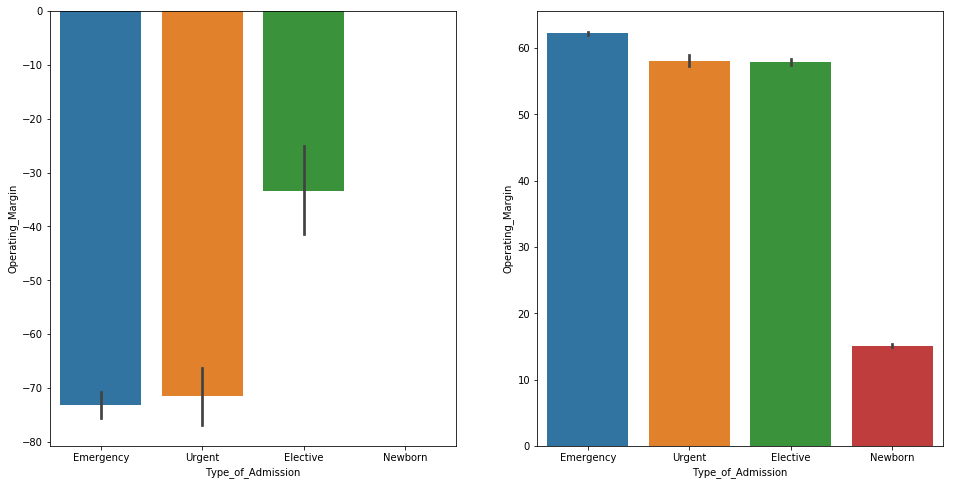

In [62]:
fig, ax =plt.subplots(figsize=(16,8), ncols=2, nrows=1)
sns.barplot(x='Type_of_Admission', y='Operating_Margin', data=loss, order=['Emergency', 'Urgent', 'Elective', 'Newborn'], ax=ax[1])
sns.barplot(x='Type_of_Admission', y='Operating_Margin', data=gain, order=['Emergency', 'Urgent', 'Elective', 'Newborn'], ax=ax[0])

## Length of Stay / Profit and Loss:

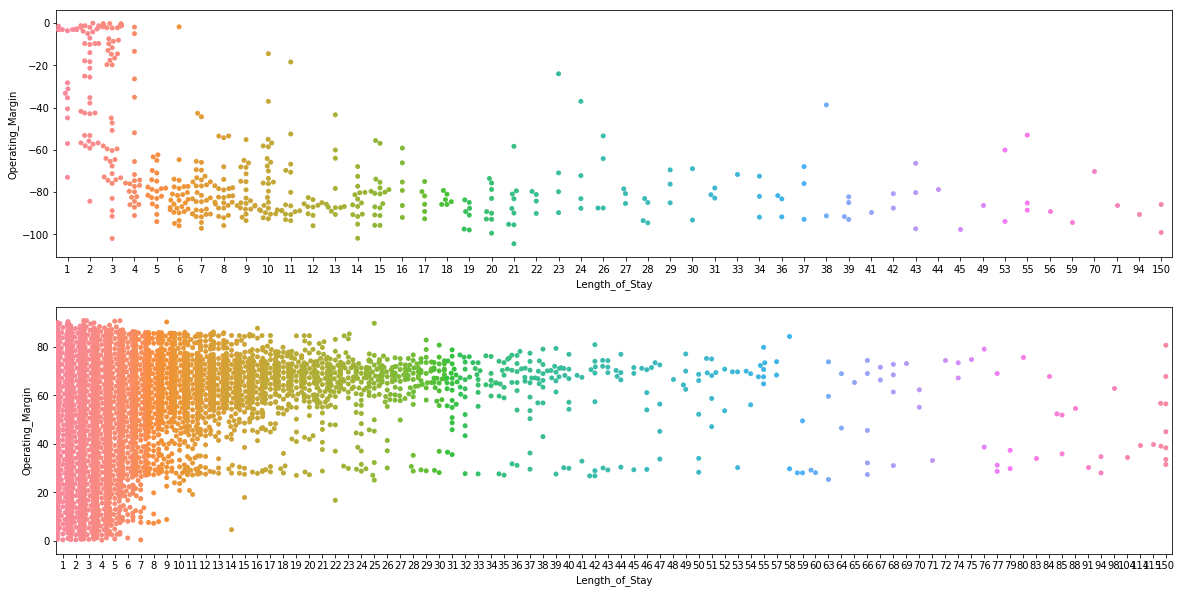

In [63]:
fig, ax = plt.subplots(figsize=(20,10), ncols=1, nrows=2)
sns.swarmplot(x='Length_of_Stay', y='Operating_Margin', data=loss, ax=ax[0])
sns.swarmplot(x='Length_of_Stay', y='Operating_Margin', data=gain, ax=ax[1]);

In [77]:
# Examining features that an EMS worker would be able to assess during an encounter with a patient
features = nyu[["Type_of_Admission", "APR_Risk_of_Mortality", "APR_MDC_Description"]]
x = pd.get_dummies(features, columns=["Type_of_Admission", "APR_Risk_of_Mortality", "APR_MDC_Description"])
x.columns = x.columns.str.replace(' ', '_')
x = x.drop(columns=['Type_of_Admission_Elective', "APR_MDC_Description_Newborns_and_Other_Neonates_with_Conditions_Originating_in_the_Perinatal_Period"], axis=0)
y = nyu.Profitable
class_names = set(y)

## Feature Correlation Heatmap

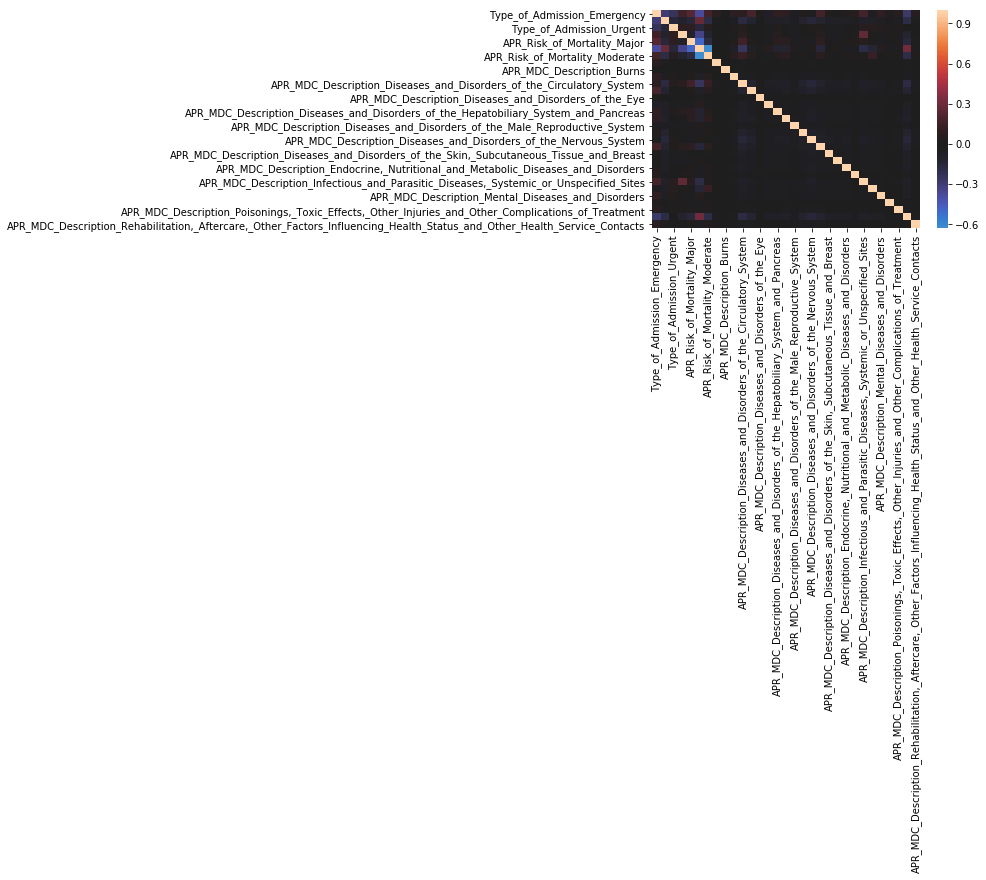

In [78]:
sns.heatmap(x.corr(), center=0);

<a id='Part_4'></a>

## Modeling our Data

In [258]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.60, stratify=y)

In [259]:
# there is class imbalance, so we will use SMOTE to manage this
y_train.value_counts()

1    16546
0      281
Name: Profitable, dtype: int64

In [260]:
smo = SMOTE()
X_train_res, y_train_res = smo.fit_sample(X_train, y_train.ravel())

The use of a pipeline function will help us determine the best classifier to use:

In [357]:
pipeline(31, X_train_res, y_train_res, X_test, y_test)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=31, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])
Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=31, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])
Pipeline(memory=None,
     steps=[('pca'

Looks like they would all work out well! 
Let's start with a Logistic Regression:

In [262]:
logreg = LogisticRegression()
model_log = logreg.fit(X_train_res, y_train_res)

In [263]:
y_hat_test_lr = logreg.predict(X_test)
y_hat_train_lr = logreg.predict(X_train_res)

Evaluation of the regression:

Training Precision:  0.8804401111171632
Testing Precision:  0.9975945970950134



Training Recall:  0.9769128490269552
Testing Recall:  0.9776065276518585



Training Accuracy:  0.9221261936419678
Testing Accuracy:  0.9756641112497771



Training F1 Score:  0.9261710356682423
Testing F1 Score:  0.9874994276294702



Confusion matrix, without normalization


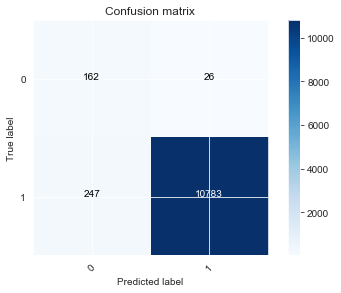




Normalized confusion matrix


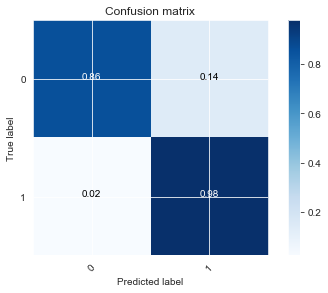

In [264]:
evaluate(y_train_res, y_hat_train_lr, y_test, y_hat_test_lr)

Our regression yielded surprisingly great results! 

In [265]:
print(cross_val_score(model_log, x, y, cv=4).mean())

0.9939026373518005


In [266]:
cm_logreg = confusion_matrix(y_test, y_hat_test_lr)

In [267]:
y_score = logreg.fit(X_train_res, y_train_res).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.9753650585443955


AUC: 0.9753650585443955


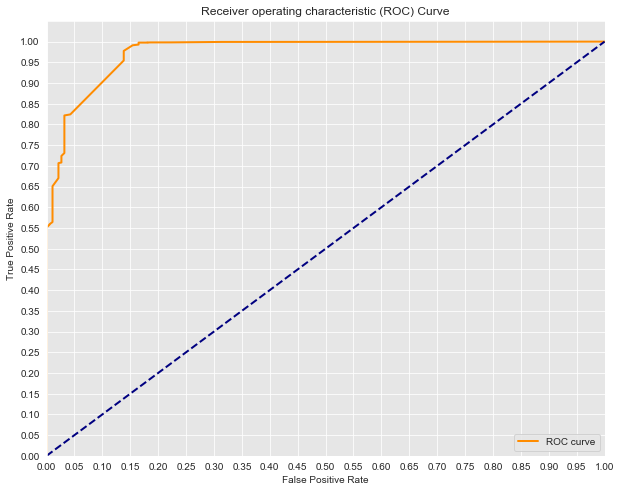

In [268]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Onto Random Forest...

In [270]:
clf = RandomForestClassifier()
clf_model = clf.fit(X_train_res, y_train_res)

In [271]:
y_hat_test_clf = clf.predict(X_test)
y_hat_train_clf = clf.predict(X_train_res)

In [272]:
residuals = np.abs(y_train_res - y_hat_train_clf)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    31184
1     1908
dtype: int64
0    0.942343
1    0.057657
dtype: float64


In [273]:
residuals = np.abs(y_test - y_hat_test_clf)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0    10978
1      240
Name: Profitable, dtype: int64
0    0.978606
1    0.021394
Name: Profitable, dtype: float64


Training Precision:  0.910948905109489
Testing Precision:  0.9973266961651918



Training Recall:  0.980539103106491
Testing Recall:  0.9808703535811424



Training Accuracy:  0.9423425601353802
Testing Accuracy:  0.9786058120877161



Training F1 Score:  0.9444638491093258
Testing F1 Score:  0.9890300758753086



Confusion matrix, without normalization


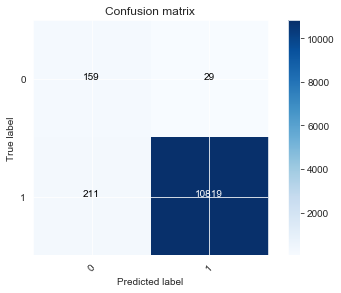




Normalized confusion matrix


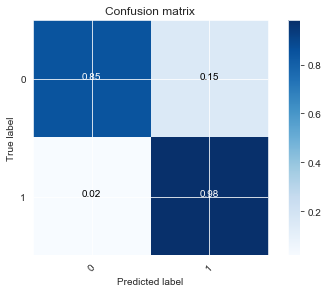

In [274]:
evaluate(y_train_res, y_hat_train_clf, y_test, y_hat_test_clf)

In [275]:
cm_clf = confusion_matrix(y_test, y_hat_test_clf)

In [276]:
print(cross_val_score(clf_model, x, y, cv=4).mean())

0.994223566698993


Let's try to maximize recall as much as possible 

In [280]:
pipe_rf = Pipeline([('pca', PCA()),('clf', RandomForestClassifier())])
param_grid_forest = [{'clf__n_estimators': [10], 'clf__criterion': ['entropy', 'gini'], 'clf__max_depth': [2, 3, 4],'clf__min_samples_leaf':[0.01, 0.2 ,0.25], 'clf__min_samples_split':[0.2, 0.4, 0.6]}]

In [279]:
gs_rf = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_forest, scoring='recall', cv=3, verbose=0, return_train_score = True)
gs_rf.fit(X_train_res, y_train_res)
print('Best recall score: %.3f' % gs_rf.best_score_)
print('\nBest params:\n', gs_rf.best_params_)

Best recall score: 0.995

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__min_samples_leaf': 0.01, 'clf__min_samples_split': 0.2, 'clf__n_estimators': 10}


In [281]:
clf_recall = RandomForestClassifier(criterion= 'entropy', max_depth=4, min_samples_leaf=0.01, min_samples_split=0.2, n_estimators=10)
clf_recall_model = clf_recall.fit(X_train_res, y_train_res)

In [282]:
y_hat_test_rec = clf_recall.predict(X_test)
y_hat_train_rec = clf_recall.predict(X_train_res)

Training Precision:  0.8608500417710944
Testing Precision:  0.9971907566832805



Training Recall:  0.9964341834884565
Testing Recall:  0.9976427923844061



Training Accuracy:  0.9176840323945364
Testing Accuracy:  0.9949188803708325



Training F1 Score:  0.92369320410107
Testing F1 Score:  0.997416723317471



Confusion matrix, without normalization


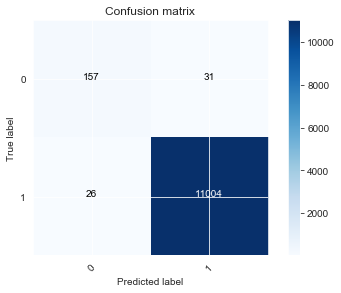




Normalized confusion matrix


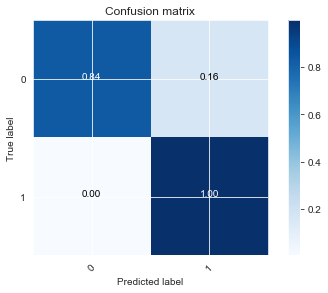

In [283]:
evaluate(y_train_res, y_hat_train_rec, y_test, y_hat_test_rec)

In [284]:
cm_recall = confusion_matrix(y_test, y_hat_test_rec)

In [294]:
adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(X_train_res, y_train_res)

In [321]:
adaboost_train_preds = adaboost_clf.predict(X_train_res)
adaboost_test_preds = adaboost_clf.predict(X_test)

Training Precision:  0.9095369691500761
Testing Precision:  0.9975845410628019



Training Recall:  0.9746766590112413
Testing Recall:  0.9735267452402538



Training Accuracy:  0.938867399975825
Testing Accuracy:  0.9716527010162239



Training F1 Score:  0.9409808326282929
Testing F1 Score:  0.9854088281178306



Confusion matrix, without normalization


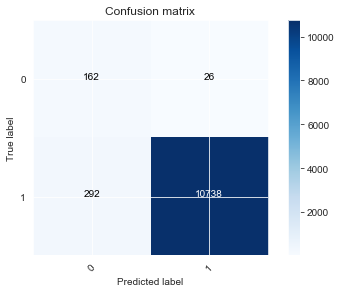




Normalized confusion matrix


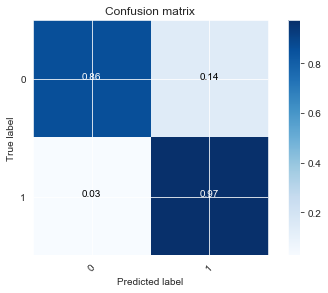

In [323]:
evaluate(y_train_res, adaboost_train_preds, y_test, adaboost_test_preds)

In [301]:
adaboost_classification_report = classification_report(y_test, adaboost_test_preds)
print(adaboost_classification_report)

              precision    recall  f1-score   support

           0       0.36      0.86      0.50       188
           1       1.00      0.97      0.99     11030

   micro avg       0.97      0.97      0.97     11218
   macro avg       0.68      0.92      0.75     11218
weighted avg       0.99      0.97      0.98     11218



In [303]:
print('Mean Adaboost Cross-Val Score (k=5):')
print(cross_val_score(adaboost_clf, x, y, cv=5).mean())

Mean Adaboost Cross-Val Score (k=5):
0.9939739766904054


In [296]:
gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(X_train_res, y_train_res)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [297]:
gbt_clf_train_preds = gbt_clf.predict(X_train_res)
gbt_clf_test_preds = gbt_clf.predict(X_test)

Training Precision:  0.8696020770412759
Testing Precision:  0.9970866715222141



Training Recall:  0.9919013658890367
Testing Recall:  0.9929283771532185



Training Accuracy:  0.9215822555300375
Testing Accuracy:  0.9901943305402032



Training F1 Score:  0.9267342386854514
Testing F1 Score:  0.995003179794676



Confusion matrix, without normalization


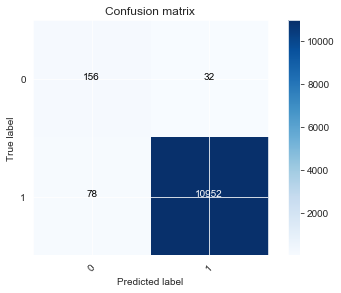




Normalized confusion matrix


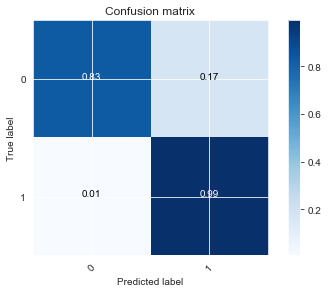

In [324]:
evaluate(y_train_res, gbt_clf_train_preds, y_test, gbt_clf_test_preds)

In [302]:
gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
print(gbt_classification_report)

              precision    recall  f1-score   support

           0       0.67      0.83      0.74       188
           1       1.00      0.99      1.00     11030

   micro avg       0.99      0.99      0.99     11218
   macro avg       0.83      0.91      0.87     11218
weighted avg       0.99      0.99      0.99     11218



In [304]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, x, y, cv=5).mean())

Mean GBT Cross-Val Score (k=5):
0.9941879439956665


In [313]:
xgbcclf = XGBClassifier()
xgb = xgbcclf.fit(X_train_res, y_train_res)

Training Precision:  0.8685366499073829
Testing Precision:  0.9971774560684694



Training Recall:  0.9918409283210443
Testing Recall:  0.9929283771532185



Training Accuracy:  0.9208570047141303
Testing Accuracy:  0.9902834729898378



Training F1 Score:  0.9261025366101409
Testing F1 Score:  0.9950483805024303



Confusion matrix, without normalization


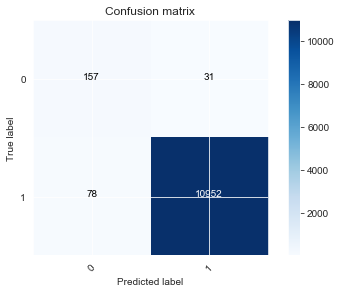




Normalized confusion matrix


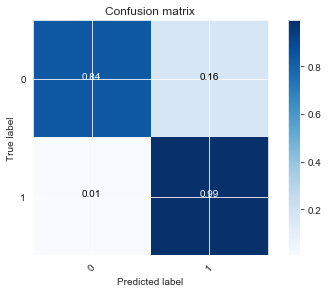

In [326]:
y_hat_train_xgb = xgbcclf.predict(X_train_res)
y_hat_test_xgb = xgbcclf.predict(X_test.values)
xgb_confusion_matrix = confusion_matrix(y_test, y_hat_test_xgb)
evaluate(y_train_res, y_hat_train_xgb, y_test, y_hat_test_xgb)

<a id='Part_5'></a>

# Final Model! 

In [348]:
final_model = clf_model

Inspecting the features of our final model:

In [349]:
for feature, importance in zip(x.columns, final_model.feature_importances_):
    print("{} -> {} \n\n".format(feature, (round(importance, 3))))

Type_of_Admission_Emergency -> 0.058 


Type_of_Admission_Newborn -> 0.046 


Type_of_Admission_Urgent -> 0.014 


APR_Risk_of_Mortality_Extreme -> 0.009 


APR_Risk_of_Mortality_Major -> 0.024 


APR_Risk_of_Mortality_Minor -> 0.081 


APR_Risk_of_Mortality_Moderate -> 0.002 


APR_MDC_Description_Alcohol/Drug_Use_and_Alcohol/Drug_Induced_Organic_Mental_Disorders -> 0.001 


APR_MDC_Description_Burns -> 0.0 


APR_MDC_Description_Diseases_and_Disorders_of_Blood,_Blood_Forming_Organs_and_Immunological_Disorders -> 0.004 


APR_MDC_Description_Diseases_and_Disorders_of_the_Circulatory_System -> 0.051 


APR_MDC_Description_Diseases_and_Disorders_of_the_Digestive_System -> 0.037 


APR_MDC_Description_Diseases_and_Disorders_of_the_Eye -> 0.001 


APR_MDC_Description_Diseases_and_Disorders_of_the_Female_Reproductive_System -> 0.005 


APR_MDC_Description_Diseases_and_Disorders_of_the_Hepatobiliary_System_and_Pancreas -> 0.007 


APR_MDC_Description_Diseases_and_Disorders_of_the_Kidney_and

In [350]:
feature_importance = pd.DataFrame({'Variable':x.columns, 'Importance':final_model.feature_importances_}, index=x.columns).sort_values('Importance', ascending=True)

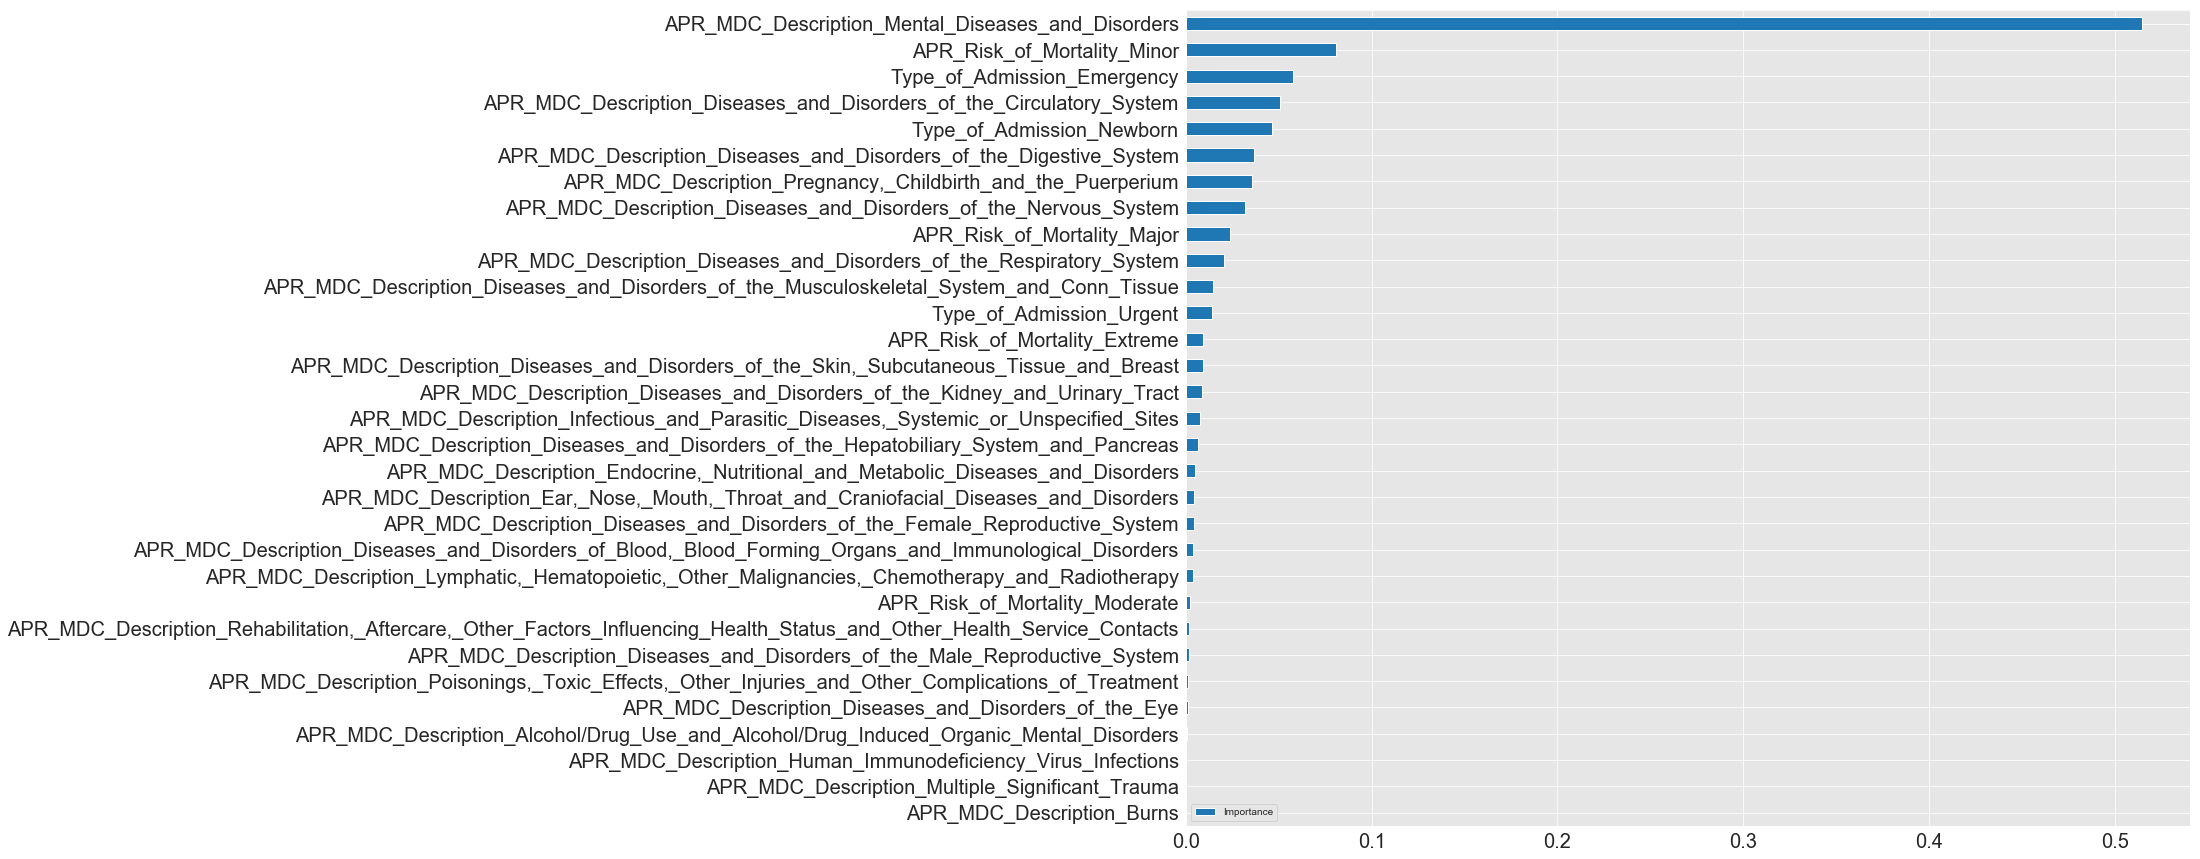

In [355]:
feature_importance.plot(kind='barh', sort_columns=True, figsize=(18,15), fontsize=20);

Waterfall Chart to understand the interaction between features:

In [338]:
row = X_test.values[None,200]
prediction, bias, contributions = ti.predict(clf_model, row)
contributions = [contributions[0][i][0] for i in range(len(contributions[0]))]

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

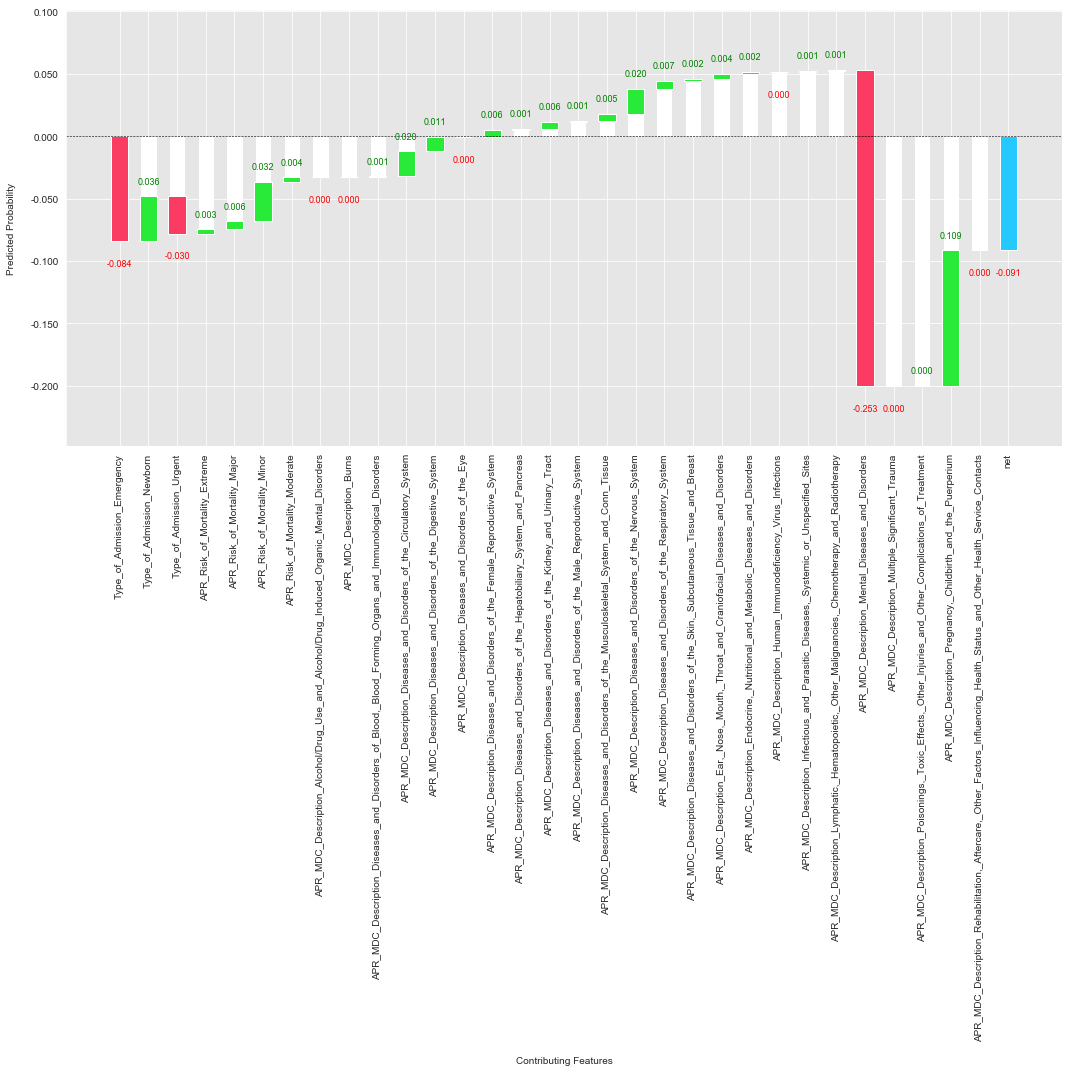

In [339]:
waterfall_chart.plot(x.columns,contributions, rotation_value=90,formatting='{:,.3f}', x_lab="Contributing Features", y_lab="Predicted Probability")


In [340]:
row

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=uint8)

In [345]:
row2 = X_test.values[None,222]
prediction, bias, contributions = ti.predict(clf_model, row2)
contributions = [contributions[0][i][0] for i in range(len(contributions[0]))]

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

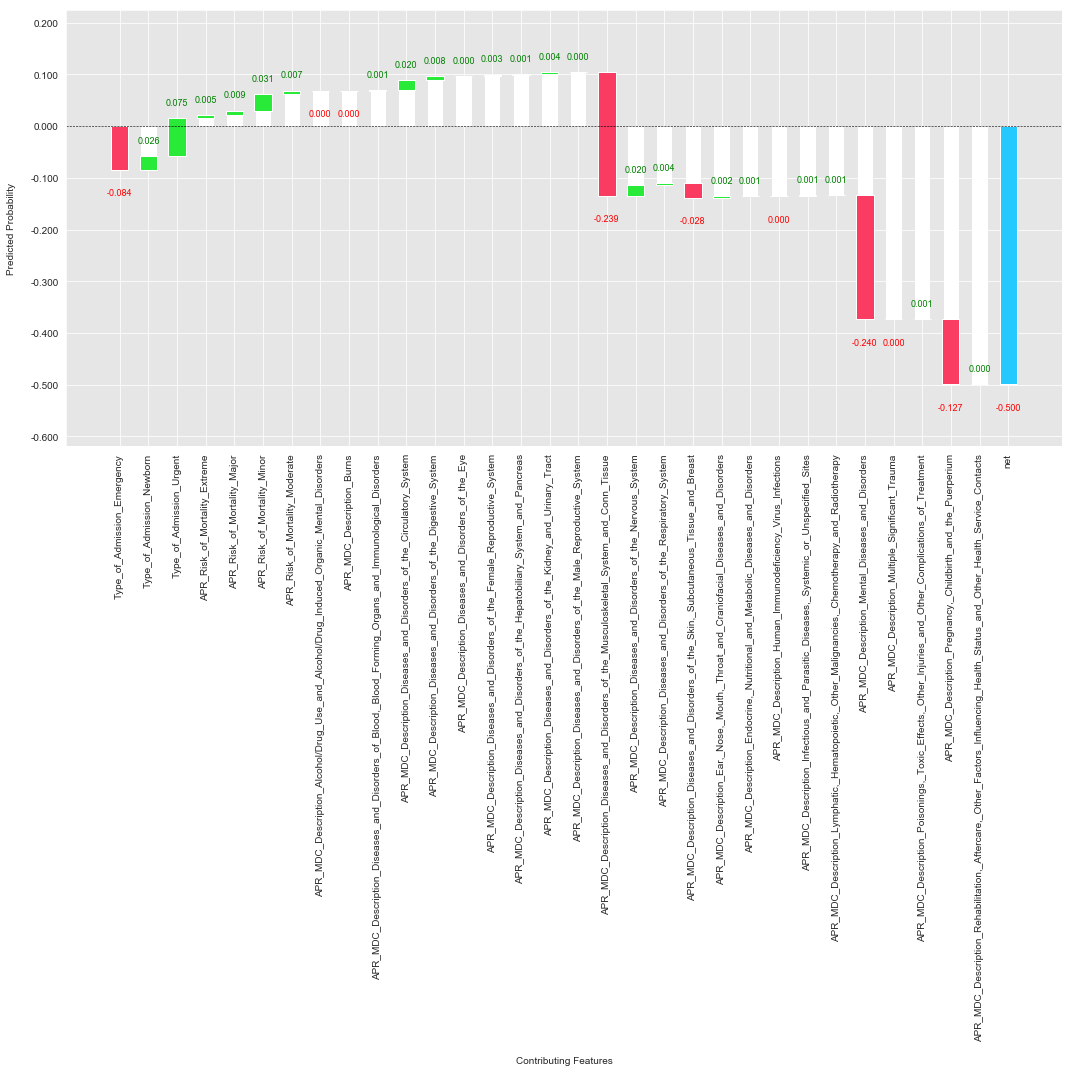

In [346]:
waterfall_chart.plot(x.columns,contributions, rotation_value=90,formatting='{:,.3f}', x_lab="Contributing Features", y_lab="Predicted Probability")

In [347]:
row2

array([[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

<a id='Part_6'></a>

# Conclusions:
1. Our model has good accuracy, precision, and recall! 
2. The features help to predict whether or not a patient encounter in the hospital will be profitable or not
3. Certain conditions and admission circumstances predict profitability

<a id='Part_7'></a>

# Recommendations:
1. EMS workers should be routed to these specific cases
2. EMS workers should be educated regarding these indicators to increase compliance
3. This model can be used in an algorithm for the hospital's ambulance routing system

<a id='Part_8'></a>

# Future Work:

1. Test model on data sets for years after 2012
2. Continue to improve model based on new data
3. Examine other possible contributors to profitability in the hospital using additional data sets